# Optimized Maize Yield Prediction

This notebook refactors the previous model into a linear, script-style format and incorporates best practices for model training and evaluation.

### Key Optimizations:
1.  **Train/Validation/Test Split**: The data is split into three sets:
    *   **Training Set (80%)**: Used to train the model.
    *   **Validation Set (10%)**: Used to monitor performance during training and tune hyperparameters.
    *   **Test Set (10%)**: A completely held-out set used for the final, unbiased evaluation of the model.
2.  **Regularization**: The neural network includes `BatchNorm1d` and `Dropout` layers to improve generalization and reduce overfitting.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

## 1. Load and Preprocess Data

In [2]:
# Load the dataset
data_path = "C1.162_PHENOnENV_PCA.csv"
# data_path = "C1.ALL_PHENOnENV_PCA.csv"
df = pd.read_csv(data_path)

# Identify features and target
genotypic_features = [f'principal component {i}' for i in range(1, 14)]
environmental_features = ['X05_PRCP', 'X05_TAVG', 'X06_DP01', 'clay_5_15cm']
target_feature = 'YLD_BE'

# Combine all relevant columns for preprocessing
all_features = genotypic_features + environmental_features + [target_feature]
df_subset = df[all_features]

# Handle missing values using mean imputation
print("Handling missing values...")
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df_subset), columns=df_subset.columns)

# Separate features and target
X = df_imputed[genotypic_features + environmental_features]
y = df_imputed[target_feature]

print("Data loading and initial preprocessing complete.")
print(f"Feature matrix shape: {X.shape}")

Handling missing values...
Data loading and initial preprocessing complete.
Feature matrix shape: (1260, 17)


## 2. Split Data into Training, Validation, and Test Sets

In [3]:
# Split data into 80% training and 20% temporary (for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the 20% temporary set into 10% validation and 10% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 1008
Validation set size: 126
Test set size: 126


## 3. Scale Features

In [4]:
# Scale features based ONLY on the training data to prevent data leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling complete.")

Feature scaling complete.


## 4. Create PyTorch DataLoaders

In [5]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print("PyTorch DataLoaders created.")

PyTorch DataLoaders created.


## 5. Define and Instantiate the Model

In [6]:
class MaizeYieldPredictor(nn.Module):
    """
    Defines the neural network architecture with Dropout and Batch Normalization.
    """
    def __init__(self, input_size, dropout_rate=0.5):
        super(MaizeYieldPredictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)

# Instantiate the model, loss function, and optimizer
input_size = X_train_tensor.shape[1]
model = MaizeYieldPredictor(input_size, dropout_rate=0.4)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("Model instantiated.")
print(model)

Model instantiated.
MaizeYieldPredictor(
  (network): Sequential(
    (0): Linear(in_features=17, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=64, out_features=1, bias=True)
  )
)


## 6. Train the Model

In [7]:
num_epochs = 100
history = {'train_loss': [], 'val_loss': []}

print("Starting model training...")
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    # Validation loop
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            epoch_val_loss += criterion(outputs, labels).item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    history['val_loss'].append(avg_val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

print("Model training complete.")

Starting model training...
Epoch [10/100], Train Loss: 15979.1384, Validation Loss: 15505.4221
Epoch [10/100], Train Loss: 15979.1384, Validation Loss: 15505.4221
Epoch [20/100], Train Loss: 7353.6655, Validation Loss: 6934.8967
Epoch [20/100], Train Loss: 7353.6655, Validation Loss: 6934.8967
Epoch [30/100], Train Loss: 1905.4304, Validation Loss: 1360.0640
Epoch [30/100], Train Loss: 1905.4304, Validation Loss: 1360.0640
Epoch [40/100], Train Loss: 436.4170, Validation Loss: 381.8886
Epoch [40/100], Train Loss: 436.4170, Validation Loss: 381.8886
Epoch [50/100], Train Loss: 325.8510, Validation Loss: 220.9885
Epoch [50/100], Train Loss: 325.8510, Validation Loss: 220.9885
Epoch [60/100], Train Loss: 287.3340, Validation Loss: 224.8420
Epoch [60/100], Train Loss: 287.3340, Validation Loss: 224.8420
Epoch [70/100], Train Loss: 256.7223, Validation Loss: 226.4458
Epoch [70/100], Train Loss: 256.7223, Validation Loss: 226.4458
Epoch [80/100], Train Loss: 231.2145, Validation Loss: 227.23

## 7. Evaluate the Model

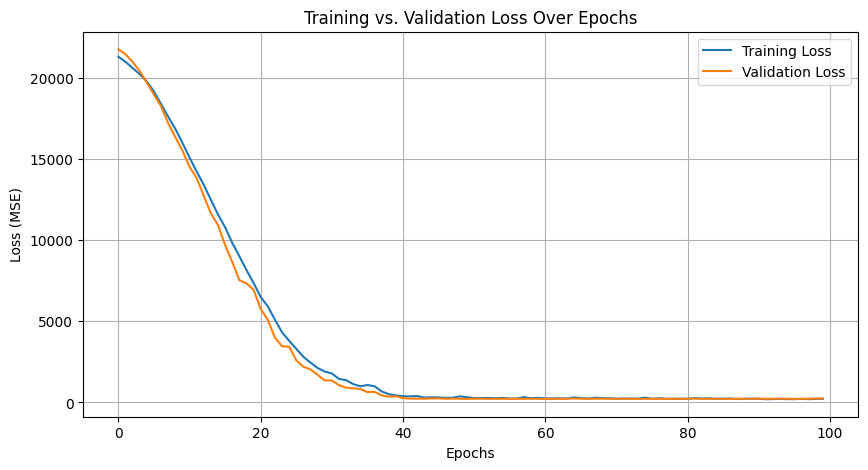

Final Test Set Performance:
  RMSE: 15.2508
  R-squared (R²): 0.5412


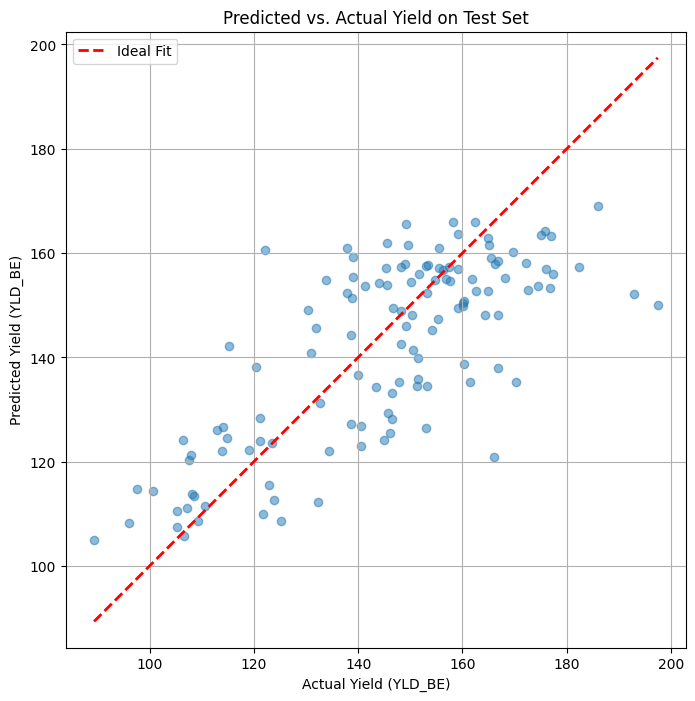

In [8]:
# --- Plot Training vs. Validation Loss ---
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# --- Final Evaluation on the Test Set ---
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        all_preds.append(outputs.numpy())
        all_labels.append(labels.numpy())

# Flatten the lists of arrays
all_preds = np.concatenate(all_preds).ravel()
all_labels = np.concatenate(all_labels).ravel()

# --- Calculate and Print Metrics ---
mse = mean_squared_error(all_labels, all_preds)
rmse = np.sqrt(mse)
r2 = r2_score(all_labels, all_preds)

print(f"Final Test Set Performance:")
print(f"  RMSE: {rmse:.4f}")
print(f"  R-squared (R²): {r2:.4f}")

# --- Plot Predicted vs. Actual Values on Test Set ---
plt.figure(figsize=(8, 8))
plt.scatter(all_labels, all_preds, alpha=0.5)
plt.plot([min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], '--', color='red', lw=2, label='Ideal Fit')
plt.title('Predicted vs. Actual Yield on Test Set')
plt.xlabel('Actual Yield (YLD_BE)')
plt.ylabel('Predicted Yield (YLD_BE)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

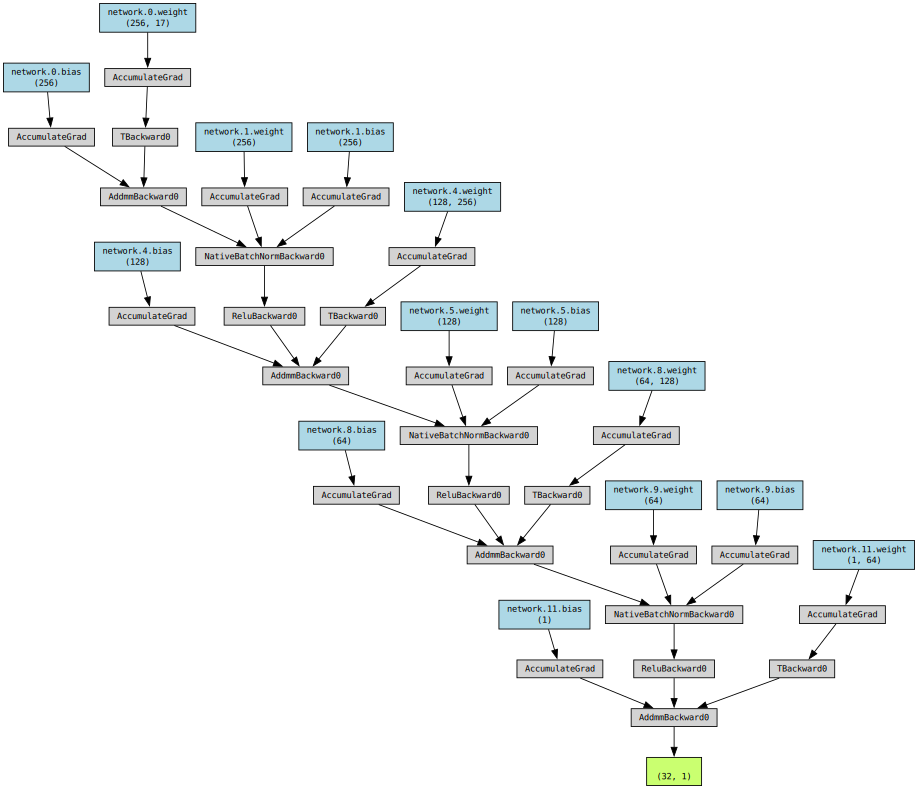

In [9]:
from torchviz import make_dot

# Get a single batch from the train_loader to visualize the graph
for inputs, labels in train_loader:
    sample_input = inputs
    break

# Generate the visualization
y = model(sample_input)
dot = make_dot(y, params=dict(model.named_parameters()))

# Display the graph
dot

## 8. Save the Trained Model

Finally, we save the trained model's state dictionary to a file. This allows us to load the model later for inference or further training without having to retrain it from scratch.

In [10]:
# Define the path to save the model
model_save_path = "maize_yield_predictor_nn02.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to maize_yield_predictor_nn02.pth
